# Tutorial: Confidence Regions Construction + Drawing

A notebook detailing how to construct and visualize confidence tubes, as well as assess coverage.

Jimmy Butler

In [1]:
library(mvtnorm)
library(ggplot2)

source('~/isolines_uq/scripts/R/confidence_regions/modules/distributionIsolines.R')
source('~/isolines_uq/scripts/R/confidence_regions/modules/confidenceRegions.R')
source('~/isolines_uq/scripts/R/confidence_regions/modules/utils.R')

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘ks’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: mgcv

Warning message:
“package ‘mgcv’ was built under R version 4.2.3”
Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-42. For overview type 'help("mgcv-package")'.

Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘data.table’ was built under R version 4.2.3”

Attaching package: ‘data.table’


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    bet

### Data

Let's first simulate data from a bivariate $t$ distribution, with $\pmb{\mu} = \pmb{0}$, $\pmb{\Sigma} = \begin{bmatrix} 1 & 0.7 \\ 0.7 & 1 \end{bmatrix}$, and $\nu = 4$. We'll simulate $n=10000$ many points.

In [2]:
dat <- data.frame(rmvt(n=10000, df=4, sigma=matrix(c(1,0.7,0.7,1), nrow=2)))

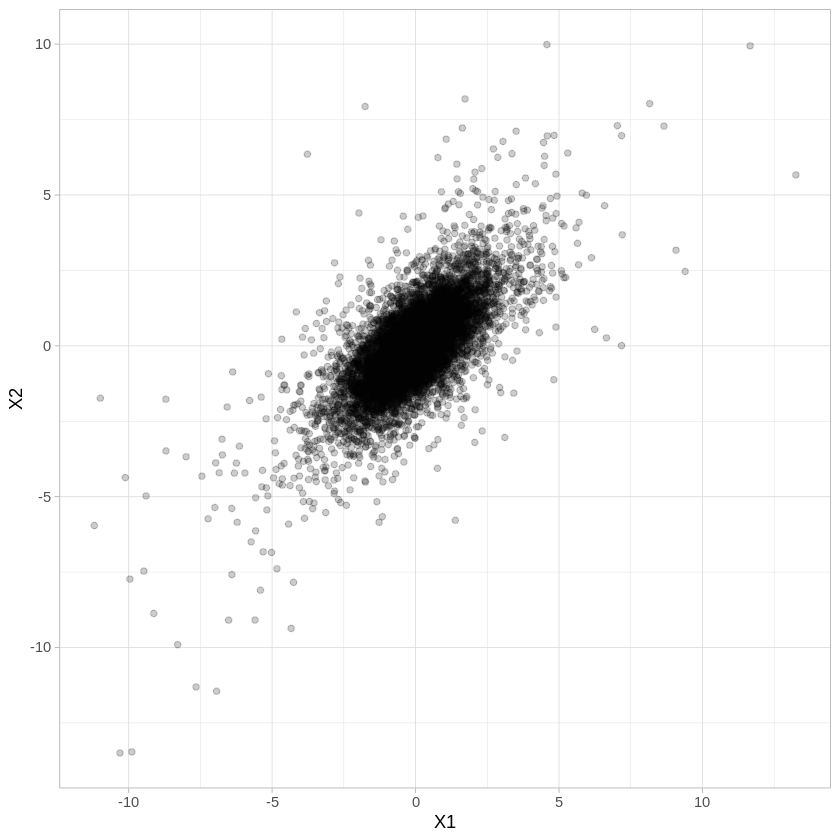

In [3]:
plt1 <- ggplot() + geom_point(data=dat, aes(x=X1, y=X2), alpha=0.2) + theme_light()
plt1

Let's suppose we want to draw confidence tubes for the $q=0.05$ isoline and the $p=0.001$ isoline, using the non-extreme and extreme methods, respectively. Let's first just compute and visualize these isolines.

In [4]:
q_isoline <- drawIsoline(dist='bivt', 
                        numCoords=200, 
                        gridLbs=c(-2,-2), 
                        gridUbs=c(100, 100), 
                        prob=0.05)

p_isoline <- drawIsoline(dist='bivt', 
                        numCoords=200, 
                        gridLbs=c(-2,-2), 
                        gridUbs=c(100, 100), 
                        prob=0.001)

Warning message:
“Removed 897 rows containing missing values (`geom_point()`).”


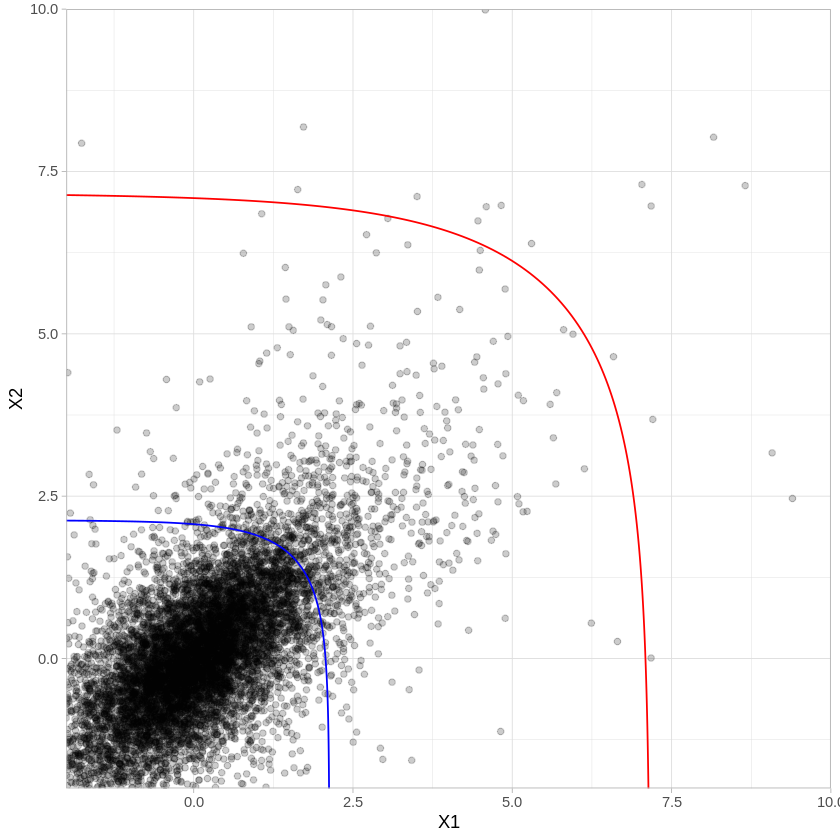

In [5]:
plt2 <- plt1 + 
        geom_line(data=q_isoline, aes(x=X1, y=X2), color='blue') +
        geom_line(data=p_isoline, aes(x=X1, y=X2), color='red') +
        scale_x_continuous(expand=c(0,0), limits=c(-2,10)) +
        scale_y_continuous(expand=c(0,0), limits=c(-2,10))
plt2

### Constructing a Confidence Tube

#### Non-Extreme Isolines

Let's first construct a confidence tube for the non-extreme isoline. Use the `computeEmpiricalRegion` function in the `confidenceRegions.R` module script. 

Here, I am setting only one `alpha`, and it will be $0.05$, so I am constructing a $95\%$ confidence tube. `B` indicates how many boostrap replicates will be used to estimate the worst case difference between the estimated and true survival functions. `lbs` indicates the lower left corner of our space, since some probability distributions have infinite support and we need to cut it off somewhere. `verbose` prints out a progress bar in case it's helpful, defaults to false.

In [6]:
region <- computeEmpiricalRegion(dat=dat,
                                 alphas=c(0.05),
                                 p=0.05,
                                 B=500,
                                 lbs=c(-2,-2),
                                 verbose=TRUE)

  |======================================================================| 100%


This gives us an estimate of $c$, where $c = \sup_{x \in \ell_{\pmb{X}}(q)} |\hat{\bar{F}}(x) - \bar{F}(x)|$, where $\ell_{\pmb{X}}(q)$ is the distribution's true $q$-isoline, $\hat{\bar{F}}(x)$ is the empirical survival function, and $\bar{F}(x)$ is the underlying distribution's true survival function. Call this estimate $\hat{c}$. The empirical confidence tube is defined as the set of all points in the 2D plane which satisfy the following condition:

\begin{align}
|\hat{\bar{F}}(x) - p| \leq \hat{c}
\end{align}

To visualize this tube, we can simply compute the boundary curves and plot that.

In [7]:
lower <- drawEmpiricalIsoline(dat=dat, 
                              n_coords=200, 
                              gridLbs=c(-2,-2), 
                              p=region$c_estimate[[1]] + region$p)

upper <- drawEmpiricalIsoline(dat=dat, 
                              n_coords=200, 
                              gridLbs=c(-2,-2), 
                              p= - region$c_estimate[[1]] + region$p)

tube <- rbind(lower, data.frame(t(rev(data.frame(t(upper))))))

Warning message:
“Removed 954 rows containing missing values (`geom_point()`).”


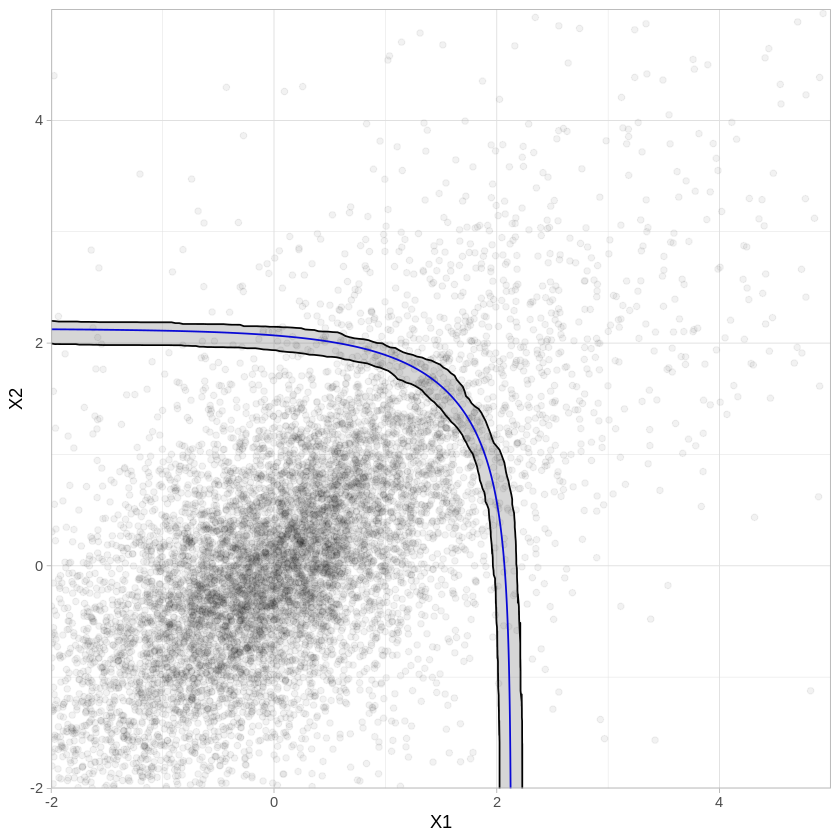

In [8]:
ggplot() + geom_point(data=dat, aes(x=X1, y=X2), alpha=0.05) + 
           geom_line(data=q_isoline, aes(x=X1, y=X2), color='blue') +
           geom_line(data=lower, aes(x=X1, y=X2)) + 
           geom_line(data=upper, aes(x=X1, y=X2)) +
           geom_polygon(data=tube, aes(x=X1, y=X2), alpha=0.2) +
           scale_x_continuous(expand=c(0,0), limits=c(-2,5)) +
           scale_y_continuous(expand=c(0,0), limits=c(-2,5)) +
           theme_light()

Visually, it seems the tube covers the true isoline. We can check this by verifying each point on the true $q$-isoline satisfies the above conditions of being in the tube.

In [9]:
# compute empirical survival function values at all points on true
# q isoline
est_survfunc <- computeEmpSurvIrregular(q_isoline, dat)
# verify every point's survival function value is within c_hat of p
all((est_survfunc <= region$p + region$c_estimate[[1]]) & 
    (est_survfunc >= region$p - region$c_estimate[[1]]))

[1] TRUE

#### Extreme Isolines

Constructing a tube for the extreme isoline requires a few steps.

1. Convert marginal distribution of data to be approximately pareto-distributed with shape parameter as $1$. (Marginal transformation also takes place in Cooley et al. 2019)
2. Apply `computeExtremeRegion` to this transformed data.
3. Draw the tube, and inverse transform the marginals of the tube.

In addition to the parameters for the non-extreme isolines, we will also need `gamma` and `xi`. `xi` is simply the extreme value index, or the reciprocal of the index of regular variation. We convert our marginal distributions to be pareto with shape parameter $1$, which means after transformation we take $\xi=1$. 

For `gamma`, our procedure uses a blended survival function, in the sense that, for non-extreme or rare probabilities, we use the empirical survival function, and for extreme probabilities, we use extreme value theory. How extreme an observation is depends on how many observations there are: our threshold between extreme and non-extreme probabilities is $n^{-\gamma}$.

In [10]:
gamma <- 1/2

# Step 1: converting the marginals to be heavy-tailed
transform <- function(pts, dat) {
        transformed_pts <- 1/(1-est_cdf(pts, dat, gamma)) - 1
        return(transformed_pts)
}
transformed_dat_X1 <- transform(dat[,1], dat[,1])
transformed_dat_X2 <- transform(dat[,2], dat[,2])
transformed_dat <- data.frame(X1=transformed_dat_X1, X2=transformed_dat_X2)

In [12]:
# Step 2: construct confidence tube using transformed data
extreme_tube <- computeExtremeRegion(dat=dat,
                                     alphas=c(0.05),
                                     p=0.001,
                                     B=500,
                                     gamma=0.5,
                                     xi=1,
                                     verbose=TRUE)

  |======================================================================| 100%


We can evaluate coverage in this transformed space, by applying the marginal transformations from before to the true isoline we wish to cover. Then, we just ask if the blended survival function estimator is within $\hat{c}$ of $p$ everywhere on this transformed isoline.

In [14]:
transformed_isoline <- data.frame(X1=transform(p_isoline[,1], dat[,1]), X2=transform(p_isoline[,2], dat[,2]))
est_survfunc <- apply(transformed_isoline, 1, blendedSurvivalFunc, dat=transformed_dat, gamma=0.5, xi=1)

In [17]:
p <- extreme_tube$p
c_hat <- extreme_tube$c_estimates[[1]]
all((est_survfunc <= p + c_hat) & (est_survfunc >= p - c_hat))

[1] FALSE

To visualize the tube in the original space, we will have to draw the bounds and inverse transform them.

In [32]:
lower_trans <- drawExtremeIsoline(dat=transformed_dat, 
                              p=p + c_hat,
                              n_coords=200,
                              gridLbs=c(0,0), 
                              gamma=gamma,
                              xi=1)

upper_trans <- drawExtremeIsoline(dat=transformed_dat, 
                              p= p - c_hat,
                              n_coords=200,
                              gridLbs=c(0,0), 
                              gamma=gamma,
                              xi=1)

tube <- rbind(lower, data.frame(t(rev(data.frame(t(upper))))))

In [38]:
inv_transform <- function(pts, dat) {
        orig_pts <- est_inv_cdf(pts/(1+pts), dat=dat, gamma=1/2)
        return(orig_pts)
}

upper <- data.frame(X1=inv_transform(upper_trans[,1], dat[,1]),
                    X2=inv_transform(upper_trans[,2], dat[,2]))

lower <- data.frame(X1=inv_transform(lower_trans[,1], dat[,1]),
                    X2=inv_transform(lower_trans[,2], dat[,2]))

tube <- rbind(lower, data.frame(t(rev(data.frame(t(upper))))))

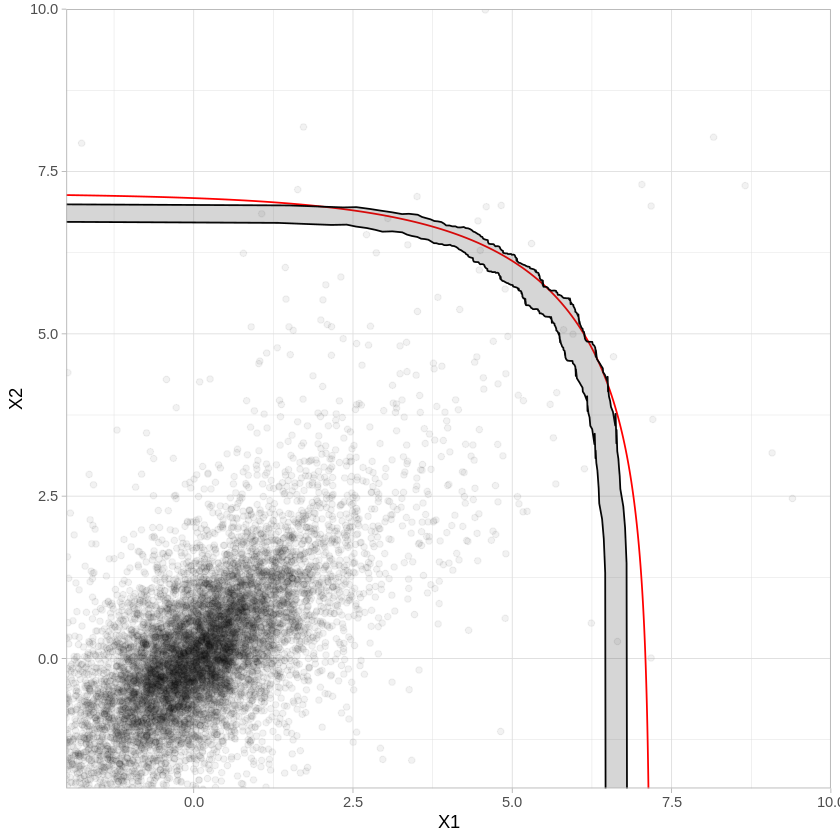

In [50]:
ggplot() + geom_point(data=dat, aes(x=X1, y=X2), alpha=0.05) + 
           geom_line(data=p_isoline, aes(x=X1, y=X2), color='red') +
           geom_line(data=lower, aes(x=X1, y=X2)) + 
           geom_line(data=upper, aes(x=X1, y=X2)) +
           geom_polygon(data=tube, aes(x=X1, y=X2), alpha=0.2) +
           coord_cartesian(xlim=c(-2,10), ylim=c(-2,10), expand=0) +
           theme_light()